In [1]:
from aqchem.chemistry import Solute, Equilibrium, EqSystem, charge_balance, atom_balance, elements
import periodictable
import numpy as np

In [13]:
substances = Hp, OHm, NH4p, NH3, H2O = [
    Solute(n, formula=periodictable.formula(n)) for n in [
        'H{+}', 'HO{-}', 'NH3 + H{+}', 'NH3', 'H2O']]
assert (Hp.charge, OHm.charge, NH4p.charge, NH3.charge, H2O.charge) == (1, -1, 1, 0, 0)

In [3]:
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 0, NH3: 1.0, H2O: 55.5}
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
equilibria = w_autop, NH4p_pr

In [4]:
reaction_system = EqSystem(equilibria, substances)

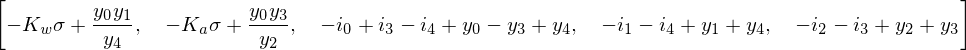

In [11]:
import sympy as sp
sp.init_printing()
ny = len(substances)
y = sp.symarray('y', ny)
i = sp.symarray('i', ny)
Kw, Ka, sigma = sp.symbols('K_w K_a sigma')
w_autop.params = Kw
NH4p_pr.params = Ka
srs = EqSystem(equilibria, substances)
srs.f(y, i, scaling=sigma)

In [8]:
np.set_printoptions(4, linewidth=120)
scaling = 1e8
res = reaction_system.root(init_conc, scaling=1e8, logC=True, square=False)
res.success

(5, 5)
[  2.3026   2.3026 -27.631   18.4207  22.4371]
[  2.3026   2.3026 -27.631   18.4207  22.4371]
[  2.3026   2.3026 -27.631   18.4207  22.4371]
[  2.3026   2.3026 -26.631   18.4207  22.4371]
[  2.3026   2.3026 -26.049   18.4207  22.4371]
[  2.3026   2.3026 -25.312   18.4207  22.4371]
[  2.3026   2.3026 -24.6356  18.4207  22.4371]
[  2.3026   2.3026 -23.936   18.4207  22.4371]
[  2.3026   2.3026 -23.2453  18.4207  22.4371]
[  2.3026   2.3026 -22.5516  18.4207  22.4371]
[  2.3026   2.3026 -21.8564  18.4207  22.4371]
[  2.3026   2.3026 -21.175   18.4207  22.4371]
[  2.3026   2.3026 -20.421   18.4207  22.4371]
[  2.3025   2.3025 -19.963   18.4207  22.4371]
[  2.3017   2.3018 -21.963   18.4206  22.4371]
[  2.3026   2.3026 -19.6588  18.4207  22.4371]
[  2.3025   2.3025 -19.3687  18.4207  22.4371]
[  2.3023   2.3023 -20.3493  18.4207  22.4371]
[  2.3025   2.3026 -18.8687  18.4207  22.4371]
[  2.3025   2.3025 -18.2426  18.4207  22.4371]
[  2.3026   2.3026 -17.1124  18.4207  22.4371]
[  2.3

/home/bjorn/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in exp
  """


False

In [7]:
res.x**2/1e12

array([  5.8661e-13,   1.3422e-07,   6.4339e-11,   8.4595e-11,   1.2586e-10])